In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2021/train.csv
/kaggle/input/tabular-playground-series-aug-2021/test.csv


In [9]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2021/train.csv", index_col="id")
test  = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2021/test.csv", index_col="id")
target = train["loss"]
train = train.drop("loss", axis=1)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb

In [ ]:
optuna.trial.Trial.suggest_float()

In [ ]:
sum(p[0] / 10 for p in preds)

In [ ]:
predictions = pd.DataFrame()
predictions["id"] = test.index
predictions["loss"] = sum(p[0] / 10 for p in preds)

predictions.to_csv('submission2.csv', index=False, header=predictions.columns)

# Try optuna

In [11]:
import optuna

In [ ]:
Best trial:
  Value: 7.813874324517482
  Params: 
    learning_rate: 0.09
    reg_lambda: 67.0
    reg_alpha: 26.0
    subsample: 0.46935386245355726
    colsample_bytree: 0.40308014835315986
    max_depth: 3
    min_child_weight: 3
    eta: 0.006667221356921901
    gamma: 5.21059181360353e-08
    grow_policy: depthwis

In [31]:
def getXGBparam(trial):
    param = {
        "n_estimators":10000,
        "learning_rate": 0.005,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "gpu_hist",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",
        # L2 regularization weight.
        "reg_lambda": trial.suggest_float("reg_lambda", low=50, high=100, step=1),
        # L1 regularization weight.
        "reg_alpha": trial.suggest_float("reg_alpha", low=0, high=60, step=1),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
          # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": trial.suggest_int("max_depth", 3, 13, step=2),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),}   
     
    return param

In [32]:
import numpy as np
import optuna

import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb


def objective(trial):
    
    train_x, valid_x, train_y, valid_y = train_test_split(train, target, test_size=0.25)
    
    params = getXGBparam(trial)
        
    xgb_model = xgb.XGBRegressor(**params)    
    
    
    xgb_model.fit(
            train_x,
            train_y,
            early_stopping_rounds=100,
            eval_set=[(valid_x, valid_y)],
            eval_metric="rmse",
            verbose=1000
        )

    valid_preds_rmse = mean_squared_error(xgb_model.predict(valid_x), valid_y, squared=False)

    return valid_preds_rmse


In [33]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {}. ".format(
            frozen_trial.number,
            frozen_trial.value
            )
        )

In [34]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=1337), direction="minimize", study_name="xgb_model")

study.optimize(func=objective, n_trials=100, timeout=60*30, callbacks=[logging_callback],  show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-08-22 12:53:07,663] A new study created in memory with name: xgb_model
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[0]	validation_0-rmse:10.13495
[1000]	validation_0-rmse:7.88936
[2000]	validation_0-rmse:7.86640
[3000]	validation_0-rmse:7.85577
[4000]	validation_0-rmse:7.85012
[5000]	validation_0-rmse:7.84708
[6000]	validation_0-rmse:7.84496
[6605]	validation_0-rmse:7.84431
[I 2021-08-22 12:53:54,826] Trial 0 finished with value: 7.844210308567311 and parameters: {'reg_lambda': 63.0, 'reg_alpha': 9.0, 'subsample': 0.4225012155954878, 'colsample_bytree': 0.5674535097716533, 'max_depth': 5, 'min_child_weight': 6, 'eta': 1.246072766804059e-06, 'gamma': 0.6436981767662344, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 7.844210308567311.
Trial 0 finished with best value: 7.844210308567311. 
[0]	validation_0-rmse:10.15539
[1000]	validation_0-rmse:7.89166
[2000]	validation_0-rmse:7.87505
[3000]	validation_0-rmse:7.86822
[4000]	validation_0-rmse:7.86450
[4460]	validation_0-rmse:7.86377
[I 2021-08-22 12:55:10,303] Trial 1 finished with value: 7.86368426772576 and parameters: {'reg_lambda': 69.0, 

KeyboardInterrupt: 

In [17]:
save = study.best_trial

In [ ]:
Trial 5 finished with value: 7.772870952968429 and parameters: {'reg_lambda': 92.0, 'reg_alpha': 37.0, 'subsample': 0.6516151835796308, 'colsample_bytree': 0.9979113145767096, 'max_depth': 5, 'min_child_weight': 2, 'eta': 5.1565654878984766e-08, 'gamma': 0.32498312042039534, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 7.772870952968429.
Trial 5 finished with best value: 7.772870952968429.

In [36]:
study.best_params

{'reg_lambda': 92.0,
 'reg_alpha': 37.0,
 'subsample': 0.6516151835796308,
 'colsample_bytree': 0.9979113145767096,
 'max_depth': 5,
 'min_child_weight': 2,
 'eta': 5.1565654878984766e-08,
 'gamma': 0.32498312042039534,
 'grow_policy': 'depthwise'}

In [39]:
def train_xgb():
    n_splits = 10
    
    kfd = KFold(n_splits=n_splits, shuffle=True)
    valid_rmse_tot = 0
    preds = []

    for (fold, indexes) in enumerate(kfd.split(train)):
        fold_train_X, fold_eval_X = train.loc[indexes[0]], train.loc[indexes[1]]
        fold_train_y, fold_eval_y = target.loc[indexes[0]], target.loc[indexes[1]]    

        xgb_model = xgb.XGBRegressor(
                n_estimators=10000,
                learning_rate=0.005,
                tree_method='gpu_hist',
                gpu_id=0,
                max_depth=5,
                subsample=0.6516151835796308,
                colsample_bytree=0.9979113145767096,
                n_jobs=4,
                booster= 'gbtree', 
                reg_lambda= 66.1,
                reg_alpha= 37.0,
                objective="reg:squarederror",
                min_child_weight=2,
                importance_type="total_gain",
                eta=5.1565654878984766e-08,
                gamma=0.32498312042039534,
                grow_policy= 'depthwise'
            )

        xgb_model.fit(
                fold_train_X,
                fold_train_y,
                early_stopping_rounds=200,
                eval_set=[(fold_eval_X, fold_eval_y)],
                eval_metric="rmse",
                verbose=500
            )

        test_preds = xgb_model.predict(test)
        valid_preds_rmse = mean_squared_error(xgb_model.predict(fold_eval_X), fold_eval_y, squared=False)
        valid_rmse_tot += valid_preds_rmse

        print("Fold: ",fold+1," ---- Valid rmse: ", valid_preds_rmse)

        preds.append([test_preds, valid_preds_rmse])

    valid_rmse_tot = valid_rmse_tot / n_splits
    print("-"*30)
    print(valid_rmse_tot)

    return preds

In [40]:
preds = train_xgb()

[0]	validation_0-rmse:10.09350
[500]	validation_0-rmse:7.88815
[1000]	validation_0-rmse:7.85313
[1500]	validation_0-rmse:7.84082
[2000]	validation_0-rmse:7.83246
[2500]	validation_0-rmse:7.82626
[3000]	validation_0-rmse:7.82214
[3500]	validation_0-rmse:7.81870
[4000]	validation_0-rmse:7.81628
[4500]	validation_0-rmse:7.81450
[5000]	validation_0-rmse:7.81360
[5500]	validation_0-rmse:7.81223
[6000]	validation_0-rmse:7.81123
[6500]	validation_0-rmse:7.81078
[7000]	validation_0-rmse:7.81025
[7500]	validation_0-rmse:7.80941
[8000]	validation_0-rmse:7.80912
[8500]	validation_0-rmse:7.80867
[8685]	validation_0-rmse:7.80865
Fold:  1  ---- Valid rmse:  7.808601584094246
[0]	validation_0-rmse:10.16355
[500]	validation_0-rmse:7.95690
[1000]	validation_0-rmse:7.92129
[1500]	validation_0-rmse:7.90957
[2000]	validation_0-rmse:7.90177
[2500]	validation_0-rmse:7.89585
[3000]	validation_0-rmse:7.89191
[3500]	validation_0-rmse:7.88900
[4000]	validation_0-rmse:7.88651
[4500]	validation_0-rmse:7.88493
[50

In [63]:
final_preds = (sum(i[0] for i in preds))/10

In [54]:
len(preds[:6] + preds[6:] )

10

In [55]:
preds[0]

[array([8.0197315, 4.5966606, 8.819701 , ..., 5.596646 , 5.566129 ,
        6.7225366], dtype=float32),
 7.808601584094246]

In [64]:
final_preds

array([8.192905 , 4.4265876, 8.704849 , ..., 5.938337 , 5.3302565,
       6.7835593], dtype=float32)

<AxesSubplot:ylabel='Count'>

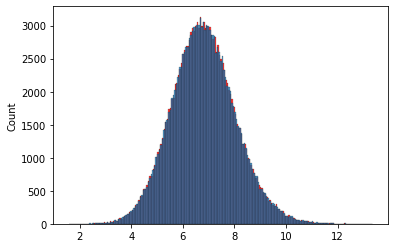

In [69]:
sns.histplot((sum(i[0] for i in preds) - preds[5][0] )/9, color="red")
sns.histplot(final_preds)


In [70]:
predictions = pd.DataFrame()
predictions["id"] = test.index
predictions["loss"] = (sum(i[0] for i in preds) - preds[5][0] )/9

predictions.to_csv('submission2.csv', index=False, header=predictions.columns)